The classification performed was mostly based on the video published by **not Otzdarva** in Youtube as of **20/08/2022**. He valued the killers according to 4 criteria which are not explicitly defined by him, namely:
* Skill ceiling: potential to snowball (e.g., slugging), control the map/generators, chase potential, etc.
* Add-ons: strength of the add-ons on the killer's general performance.
* Map dependency: influence of different map layouts in the killer's general performance.
* Unhook scenarios: potential to deal with different unhooking scenarios (e.g., several survivors rushing the hook).

To each criterion, a score between 1 to 5 was assigned based on **not Otzdarva**'s video, where 1 is the worst (e.g., *Weak*) and 5 is the best (e.g., *Strong*), and 3 is the average. Thus, the scores of 2 and 4 are assigned when **not Otzdarva** is not sure whether to assign as average or weak/strong. From our killer list, we do not have information concerning the Knight, as he was released after this video (**22/11/2022**).

It should be noted that Spirit was assigned to rank S and Artist was assigned to rank A initially. **not Otzdarva** assigned both of these to rank A+, which was not considered as a true rank in this exercise.

In [1]:
# Modules
#*****************************************************************************#
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
import joblib

In [2]:
# Load Data
#*****************************************************************************#
df = pd.read_excel('Killer_Tier_List.xlsx')
df.head()

,name,classification,skill_ceiling,add_ons,map_dependency,unhook_scenarios,total_raw_score
0,Artist,A,5,3,4,3,15
1,Blight,S,5,5,5,3,18
2,Cannibal,B,4,3,3,5,15
3,Cenobite,B,5,3,3,3,14
4,Clown,D,4,3,1,3,11


In [3]:
# Sampling - Due to a low number of observations, no testing sample is created
#*****************************************************************************#
sample = df
x_train = sample[['name','skill_ceiling','add_ons','map_dependency','unhook_scenarios']]
x_test = x_train
y_train = sample['classification']
y_test = y_train
x_train = x_train.drop('name', axis = 1, inplace = False) #Remove strings from explanatory variables
x_test = x_test.drop('name', axis = 1, inplace = False) #Remove strings from explanatory variables

<AxesSubplot:xlabel='classification', ylabel='total_raw_score'>

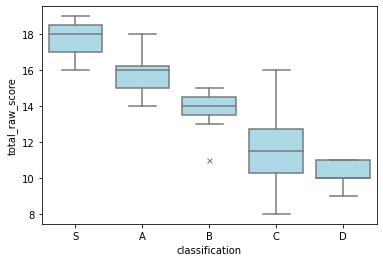

In [4]:
# Evaluate relationship of the total raw score with the final classification
#*****************************************************************************#
sns.boxplot(data = sample
            ,x = 'classification'
            ,y = 'total_raw_score'
            ,whis = 1.5 #Value multiplied by IQR to define the whiskers
            ,color = 'lightblue'
            ,saturation = 1
            ,flierprops = {'marker': 'x'}
            ,order = ['S', 'A', 'B', 'C', 'D'])

From the assessment above, the total raw score (i.e., assining a equal weight to each criteria) clearly is not sufficient for the classification performed by not Otzdarva, as we have several overlaps between classifications and even one outlier within the classification B (as shown below, this is the killer **Nemesis**).

In [5]:
# Outliers
#*****************************************************************************#
summary_table = sample[sample['classification'] == 'B'].describe().transpose()
summary_table.reset_index(inplace = True, drop = False)
Q1 = summary_table[summary_table['index'] == 'total_raw_score']['25%']
Q3 = summary_table[summary_table['index'] == 'total_raw_score']['75%']
IQR = Q3 - Q1
Lower_Bound = (Q1 - IQR * 1.5).values[0]
outliers = sample[(sample['classification'] == 'B') & (sample['total_raw_score'] < Lower_Bound)]
outliers

,name,classification,skill_ceiling,add_ons,map_dependency,unhook_scenarios,total_raw_score
16,Nemesis,B,5,1,2,3,11


In [6]:
# String encoding
#*****************************************************************************#
classification_mapping = {'S' : 5
                          ,'A' : 4
                          ,'B' : 3
                          ,'C' : 2
                          ,'D' : 1
                         }
y_train = y_train.apply(lambda x: classification_mapping[x])
y_train.head()

0    4
1    5
2    3
3    3
4    1
Name: classification, dtype: int64

The first model to create to replicate not Otzdarva's assessment will be a multiple linear classification model.

In [7]:
# Linear Regression
#*****************************************************************************#
LR = LinearRegression()
LR.fit(x_train, y_train)
print("Intercept:\n", LR.intercept_,"\n", "Coefficients:\n", LR.coef_, "\n", "R^2:\n", LR.score(x_train, y_train))

Intercept:
 -2.1697320665928364 
 Coefficients:
 [0.37756151 0.33467621 0.46218898 0.32810177] 
 R^2:
 0.7267009620576931


In [8]:
# Assign classifications
#*****************************************************************************#
def regression_mapping(prediction):
    if prediction <= 1.5:
        return 'D'
    elif prediction <= 2.5:
        return 'C'
    elif prediction <= 3.5:
        return 'B'
    elif prediction <= 4.5:
        return 'A'
    else:
        return 'S'
y_pred_LR = LR.predict(x_test)
y_pred_LR = pd.Series(y_pred_LR)
y_pred_LR = y_pred_LR.apply(lambda x: regression_mapping(x))

In [9]:
# Performance
#*****************************************************************************#
print('Accuracy score:')
print(accuracy_score(y_test, y_pred_LR))
print('')

print('Classification report:')
print(classification_report(y_test, y_pred_LR))

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_LR))

Accuracy score:
0.5517241379310345

Classification report:
              precision    recall  f1-score   support

           A       0.71      0.62      0.67         8
           B       0.60      0.86      0.71         7
           C       0.29      0.33      0.31         6
           D       0.33      0.20      0.25         5
           S       1.00      0.67      0.80         3

    accuracy                           0.55        29
   macro avg       0.59      0.54      0.55        29
weighted avg       0.56      0.55      0.54        29

Confusion matrix:
[[5 3 0 0 0]
 [0 6 1 0 0]
 [1 1 2 2 0]
 [0 0 4 1 0]
 [1 0 0 0 2]]


In [10]:
# Logistic Regression
#*****************************************************************************#
LogR = LogisticRegression(max_iter = 1000)
LogR.fit(x_train, y_train)
print("Intercept:\n", LogR.intercept_,"\n", "Coefficients:\n", LogR.coef_, "\n", "R^2:\n", LogR.score(x_train, y_train))

Intercept:
 [ 9.483598    5.42354859  0.71857454 -6.37190172 -9.25381941] 
 Coefficients:
 [[-0.69786852 -0.89619395 -0.90418433 -0.38899097]
 [-0.58896066  0.37236564 -0.46356212 -0.72369273]
 [ 0.37230246 -0.56291375 -0.02135424  0.20205922]
 [ 0.64058983  0.23234462  0.03155549  1.02097   ]
 [ 0.27393688  0.85439744  1.3575452  -0.11034551]] 
 R^2:
 0.7586206896551724


In [11]:
# Assign classifications
#*****************************************************************************#
y_pred_LogR = LogR.predict(x_test)
y_pred_LogR = pd.Series(y_pred_LogR)
y_pred_LogR = y_pred_LogR.apply(lambda x: regression_mapping(x))

In [12]:
# Performance
#*****************************************************************************#
print('Accuracy score:')
print(accuracy_score(y_test, y_pred_LogR))
print('')

print('Classification report:')
print(classification_report(y_test, y_pred_LogR))

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_LogR))

Accuracy score:
0.7586206896551724

Classification report:
              precision    recall  f1-score   support

           A       0.67      0.75      0.71         8
           B       0.67      0.57      0.62         7
           C       0.80      0.67      0.73         6
           D       0.83      1.00      0.91         5
           S       1.00      1.00      1.00         3

    accuracy                           0.76        29
   macro avg       0.79      0.80      0.79        29
weighted avg       0.76      0.76      0.75        29

Confusion matrix:
[[6 2 0 0 0]
 [2 4 1 0 0]
 [1 0 4 1 0]
 [0 0 0 5 0]
 [0 0 0 0 3]]


In [13]:
# Support Vector Machines
#*****************************************************************************#
SVM = SVC(kernel = 'linear')
SVM.fit(x_train, y_train)
print("Coefficients: \n", SVM.coef_)

Coefficients: 
 [[ 1.05457025e-01 -1.68348266e+00 -6.31224020e-01  2.10120567e-01]
 [-1.06298531e+00 -1.02387202e-01 -7.95225596e-01 -8.50445967e-01]
 [-5.00030180e-01 -2.49906596e-01 -4.99933911e-01 -5.00078059e-01]
 [-6.05197705e-02 -4.69740115e-01 -2.80378437e-01 -4.55480912e-02]
 [-6.66666667e-01  9.33673626e-01 -8.00055306e-01 -3.99832510e-01]
 [-8.67259037e-01 -2.40984277e-01 -6.50772410e-01 -1.08441832e+00]
 [ 1.77635684e-15 -4.99823665e-01 -1.00035267e+00  2.22044605e-16]
 [-4.54613393e-01 -7.27260722e-01 -2.72958840e-01 -6.36433445e-01]
 [ 3.51165981e-04 -6.66096022e-01 -6.67303155e-01  0.00000000e+00]
 [-1.03392775e-01 -4.83036123e-01 -1.24151806e+00  2.06785551e-01]]


In [14]:
# Assign classifications
#*****************************************************************************#
y_pred_SVM = SVM.predict(x_test)
y_pred_SVM = pd.Series(y_pred_SVM)
y_pred_SVM = y_pred_SVM.apply(lambda x: regression_mapping(x))

In [15]:
# Performance
#*****************************************************************************#
print('Accuracy score:')
print(accuracy_score(y_test, y_pred_SVM))
print('')

print('Classification report:')
print(classification_report(y_test, y_pred_SVM))

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_SVM))

Accuracy score:
0.7241379310344828

Classification report:
              precision    recall  f1-score   support

           A       0.71      0.62      0.67         8
           B       0.56      0.71      0.63         7
           C       0.75      0.50      0.60         6
           D       0.83      1.00      0.91         5
           S       1.00      1.00      1.00         3

    accuracy                           0.72        29
   macro avg       0.77      0.77      0.76        29
weighted avg       0.73      0.72      0.72        29

Confusion matrix:
[[5 3 0 0 0]
 [1 5 1 0 0]
 [1 1 3 1 0]
 [0 0 0 5 0]
 [0 0 0 0 3]]


In [16]:
# Random Forest
#*****************************************************************************#
RF = RandomForestClassifier()
RF.fit(x_train, y_train)

RandomForestClassifier()

In [17]:
# Assign classifications
#*****************************************************************************#
y_pred_RF = RF.predict(x_test)
y_pred_RF = pd.Series(y_pred_RF)
y_pred_RF = y_pred_RF.apply(lambda x: regression_mapping(x))

In [18]:
# Performance
#*****************************************************************************#
print('Accuracy score:')
print(accuracy_score(y_test, y_pred_RF))
print('')

print('Classification report:')
print(classification_report(y_test, y_pred_RF))

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_RF))

Accuracy score:
0.9310344827586207

Classification report:
              precision    recall  f1-score   support

           A       0.88      0.88      0.88         8
           B       0.86      0.86      0.86         7
           C       1.00      1.00      1.00         6
           D       1.00      1.00      1.00         5
           S       1.00      1.00      1.00         3

    accuracy                           0.93        29
   macro avg       0.95      0.95      0.95        29
weighted avg       0.93      0.93      0.93        29

Confusion matrix:
[[7 1 0 0 0]
 [1 6 0 0 0]
 [0 0 6 0 0]
 [0 0 0 5 0]
 [0 0 0 0 3]]


In [19]:
observed_values = pd.DataFrame(y_test)
observed_values.columns = ['Observed']
predicted_values = pd.DataFrame(y_pred_RF, columns = ['Predicted'])
names = pd.DataFrame(sample['name'])
names.reset_index(inplace = True, drop = True)
names.columns = ['Name']
mismatches = pd.concat([names, observed_values, predicted_values], axis = 1)
mismatches['ind_mismatch'] = mismatches.apply(lambda x: 1 if x.Observed != x.Predicted else 0
                                              ,axis = 1)
print(mismatches[mismatches['ind_mismatch'] == 1])

         Name Observed Predicted  ind_mismatch
12  Hillbilly        B         A             1
19        Oni        A         B             1


With a Random Forest Classifier, we are able to assign a classification to any killer in line with **not Otzdarva**'s own assessment in a very reliable manner. The main differences were the assignment of Hillbilly to rank B (instead of A) and Oni to rank A (instead of B).

What about the Knight? What rank would **not Otzdarva** give to him? Considering his review video as of **01/11/2022** from the PTB and some subsequent discussions (**23/11/2022**), the following scores should be assigned:
* Skill ceiling: 3
* Add-ons: 4
* Map dependency: 3
* Unhook scenarios: 3

In [20]:
Values = pd.DataFrame(data = [3, 4, 3, 3]).transpose()
Values.columns = ['skill_ceiling','add_ons','map_dependency','unhook_scenarios']
Knight = RF.predict(Values)[0]
KnightRank = regression_mapping(Knight)
print("Expected rank:\n", KnightRank)

Expected rank:
 B


Thus, it is expected that, in his next killer tier list, the Knight is ranked as **B**, assuming that there are no relevant changes and that his scores are in line with the ones provided above.

The following will save the model's parameters, which can be later loaded by running the following:
*loaded_rf = joblib.load("./killer_rank_model.joblib")*

In [21]:
joblib.dump(RF, "./killer_rank_model.joblib", compress = 3)
print(f"Size of data exported: {np.round(os.path.getsize('killer_rank_model.joblib') / 1024 / 1024, 2)} MB.")

Size of data exported: 0.03 MB.
